In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models
import random

# LOAD DATA

In [76]:
def load_features_labels(folder_path):
    rin = pd.read_csv(f"{folder_path}/filtered_stream_rates_rin.csv", header=None).values
    rout = pd.read_csv(f"{folder_path}/filtered_stream_rates_rout.csv", header=None).values
    eps = 1e-8
    feature = (rin - rout) / (rin + eps)

    labels = pd.read_csv(f"{folder_path}/filtered_test_info.csv", header=None)
    V = labels.iloc[:, 0].values  # Capacity
    Cross = labels.iloc[:, 1].values  # Cross traffic
    A = V - Cross  # Available Bandwidth

    y = np.column_stack((A, V))  # [A, V]
    return feature, y

In [77]:
X_d1, y_d1 = load_features_labels("Data_D1")
X_d2, y_d2 = load_features_labels("Data_D2")
X_d3, y_d3 = load_features_labels("Data_D3")

In [78]:
X_all = np.vstack([X_d1, X_d2, X_d3])
y_all = np.vstack([y_d1, y_d2, y_d3])
A_all = y_all[:, 0]

In [79]:
print("Unique values of A:", np.unique(y_all[:, 0]))
print("Unique values of C:", np.unique(y_all[:, 1]))

Unique values of A: [12.5 25.  37.5 50.  62.5 75.  87.5]
Unique values of C: [ 50. 100.]


# MASKING FOR INTERPOLATION AND EXTRAPOLATION

In [80]:
mask_train = (A_all == 25.0) | (A_all == 50.0) | (A_all == 75.0)
mask_interp = (A_all == 37.5) | (A_all == 62.5)
mask_extra = (A_all == 12.5) | (A_all == 87.5)

In [81]:
X_train, y_train = X_all[mask_train], y_all[mask_train]
X_interp, y_interp = X_all[mask_interp], y_all[mask_interp]
X_extra, y_extra = X_all[mask_extra], y_all[mask_extra]

# SCALING DATA

In [82]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_interp_scaled = scaler.transform(y_interp)
y_extra_scaled = scaler.transform(y_extra)

# FIXING THE SEEDS

In [83]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# BUILD MODELS

In [84]:
# === Build and Train Simple NN ===
def build_simple_nn(input_dim):
    tf.random.set_seed(SEED)
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(40, activation='relu'),
        layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

k = X_train.shape[1]
simple_nn = build_simple_nn(k)
simple_nn.fit(X_train, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# TRAIN SIMPLE NN

In [85]:
k = X_train.shape[1]
simple_nn = build_simple_nn(input_dim=k)  
simple_nn.fit(X_train, y_train_scaled, epochs=10, batch_size=12, validation_split=0.2, verbose=0)

# PREDICTIONS

In [86]:
pred_interp_simple = scaler.inverse_transform(simple_nn.predict(X_interp))
pred_extra_simple = scaler.inverse_transform(simple_nn.predict(X_extra))
pred_train_simple = scaler.inverse_transform(simple_nn.predict(X_train))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step


# ITERATIVE MODEL

In [87]:
def iterative_predict(X, V_true, threshold=0.1, iterations=7):
    rin = X[:, 0]  # First feature = burst stream's (rin-rout)/rin
    A_est = V_true.copy()

    for _ in range(iterations):
        rout = rin * (1 - A_est / V_true)
        feature = (rin - rout) / (rin + 1e-8)
        congested = feature > threshold
        A_est = np.where(congested, 0.90 * A_est, A_est)  # reduce A_est when congested

    return np.column_stack((A_est, V_true))

# PREDICTIONS: ITERATIVE

In [88]:
pred_interp_iter = iterative_predict(X_interp, y_interp[:, 1])
pred_extra_iter = iterative_predict(X_extra, y_extra[:, 1])
pred_train_iter = iterative_predict(X_train, y_train[:, 1])

# PRINTING METRICS

In [89]:
def print_metrics(name, y_true, y_pred):
    mse_A = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    mae_A = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    mse_V = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    mae_V = mean_absolute_error(y_true[:, 1], y_pred[:, 1])

    print(f"📈 {name}")
    print(f"  - A (Available BW): MSE = {mse_A:.2f}, MAE = {mae_A:.2f}")

In [90]:
print_metrics("Interpolation (Simple NN)", y_interp, pred_interp_simple)
print_metrics("Interpolation (Iterative Method)", y_interp, pred_interp_iter)

📈 Interpolation (Simple NN)
  - A (Available BW): MSE = 140.99, MAE = 9.49
📈 Interpolation (Iterative Method)
  - A (Available BW): MSE = 179.85, MAE = 13.37


In [91]:
print_metrics("Extrapolation (Simple NN)", y_extra, pred_extra_simple)
print_metrics("Extrapolation (Iterative Method)", y_extra, pred_extra_iter)

📈 Extrapolation (Simple NN)
  - A (Available BW): MSE = 411.36, MAE = 18.57
📈 Extrapolation (Iterative Method)
  - A (Available BW): MSE = 262.71, MAE = 14.12


In [92]:
print_metrics("Training/Test Set (Simple NN)", y_train, pred_train_simple)
print_metrics("Training/Test Set (Iterative Method)", y_train, pred_train_iter)

📈 Training/Test Set (Simple NN)
  - A (Available BW): MSE = 208.82, MAE = 11.49
📈 Training/Test Set (Iterative Method)
  - A (Available BW): MSE = 281.26, MAE = 11.90


# PLOTTING GRAPHS

In [93]:
# === Plotting grouped error bars (for A and V separately) ===
def plot_grouped_predictions(true_vals, simple_preds, iter_preds, ylabel, title):
    unique_vals = np.sort(np.unique(true_vals))
    offset = 1.5  # offset to avoid overlap
    plt.figure(figsize=(8, 5))

    models = {
        "Simple NN": simple_preds,
        "Iterative Method": iter_preds
    }

    for i, (label, preds) in enumerate(models.items()):
        means, stds = [], []
        for val in unique_vals:
            mask = true_vals == val
            if np.any(mask):
                means.append(np.mean(preds[mask]))
                stds.append(np.std(preds[mask]))
            else:
                means.append(np.nan)
                stds.append(np.nan)

        shift = (-offset if i == 0 else offset)
        shifted_x = unique_vals + shift

        plt.errorbar(
            shifted_x, means, yerr=stds, fmt='o', capsize=5, label=label,
            markersize=8, linewidth=2
        )

    plt.xlabel(f"True {ylabel} [Mbps]")
    plt.ylabel(f"Predicted {ylabel} [Mbps]")
    plt.title(title)
    plt.xticks(unique_vals)
    plt.yticks(np.arange(0, 101, 10))
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [94]:
# ==== Extract A and V for plotting ====
A_interp_true = y_interp[:, 0]
V_interp_true = y_interp[:, 1]
A_extra_true = y_extra[:, 0]
V_extra_true = y_extra[:, 1]
A_train_true = y_train[:, 0]
V_train_true = y_train[:, 1]

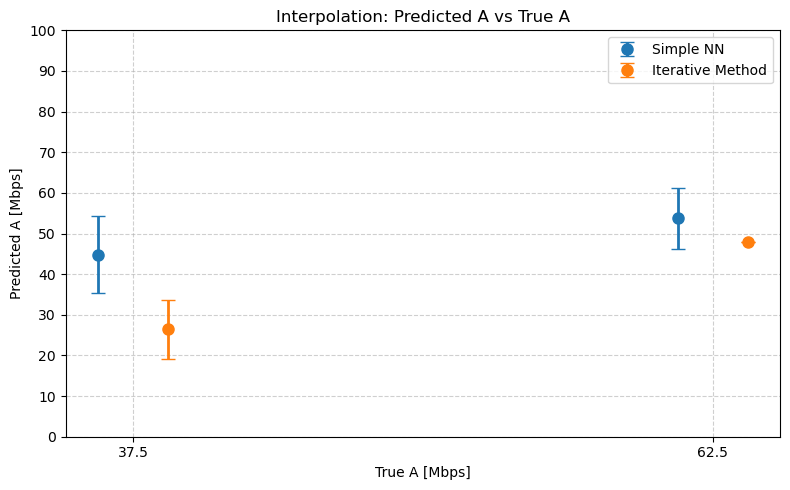

In [95]:
# ==== A plots ====
plot_grouped_predictions(A_interp_true, pred_interp_simple[:, 0], pred_interp_iter[:, 0],
                         ylabel="A", title="Interpolation: Predicted A vs True A")

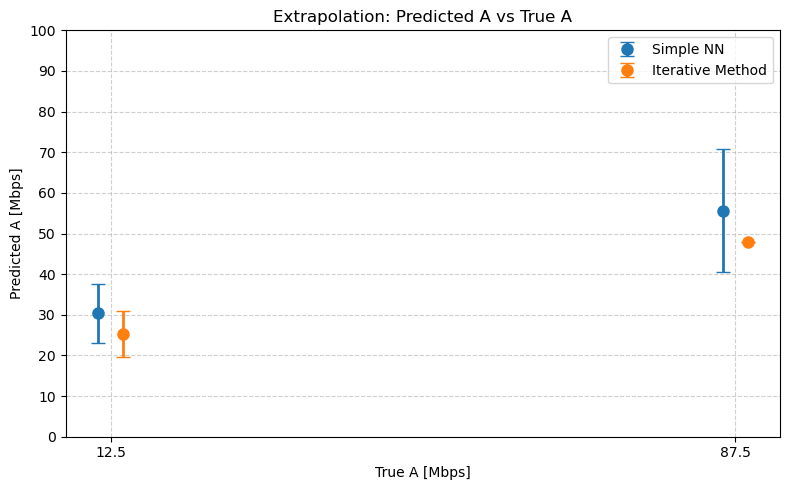

In [96]:
# ==== Plot A: Extrapolation ====
plot_grouped_predictions(
    A_extra_true, pred_extra_simple[:,0], pred_extra_iter[:,0],
    ylabel="A",title="Extrapolation: Predicted A vs True A"
)


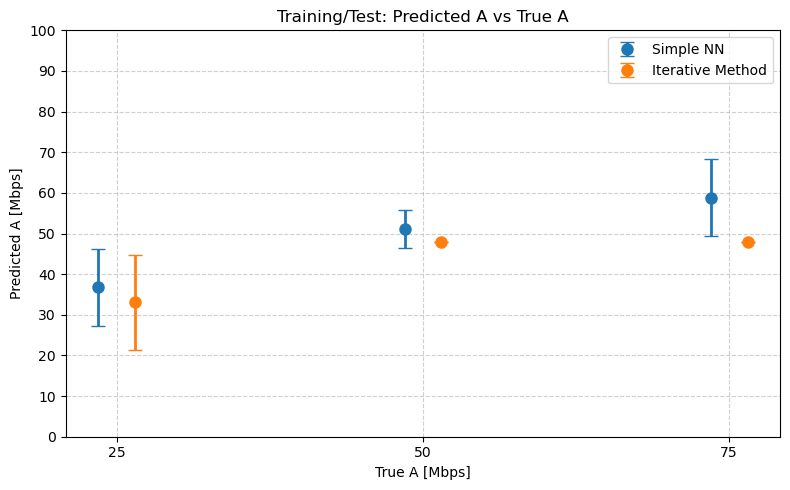

In [98]:
plot_grouped_predictions(A_train_true, pred_train_simple[:, 0], pred_train_iter[:, 0],
                         ylabel="A", title="Training/Test: Predicted A vs True A")